In [5]:
!pip install wordcloud

In [15]:
# basic library
import pandas as pd
import numpy as np
import re
import string
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# model
import torch
from torch.utils.data import DataLoader, TensorDataset

# stop words
%pip install Sastrawi
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# stememer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk corpus
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# tokenizer
from transformers import BertTokenizer
from tokenizers import Tokenizer

# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# other preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training pipline
import tensorflow as tf
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# label encoding
label_type = ['NotPromotion', 'Promotion']

Note: you may need to restart the kernel to use updated packages.


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# %pip install seaborn
# %pip install Sastrawi
# %pip install wordcloud
# %pip install torch
# %pip install transformers
# %pip install nltk
# %pip install tensorflow
# %pip install gensim --upgrade

In [16]:
combined_data = pd.read_csv('../../Dataset/dataset_combined_new - dataset_combined_new.csv', sep=',')
training_data = pd.read_csv('../../Dataset/train.csv', sep=',').dropna()
testing_data = pd.read_csv('../../Dataset/test.csv', sep=',')
validation_data = pd.read_csv('../../Dataset/val.csv')

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [17]:
index = 410
print(training_data.iloc[index, 0])
print([ord(char) for char in training_data.iloc[index, 0]])

Rezeki gak ada putusnya, makasi █▓▒▒░░░PU LAU 777░░░▒▒▓█.
[82, 101, 122, 101, 107, 105, 32, 103, 97, 107, 32, 97, 100, 97, 32, 112, 117, 116, 117, 115, 110, 121, 97, 44, 32, 109, 97, 107, 97, 115, 105, 32, 9608, 9619, 9618, 9618, 9617, 9617, 9617, 80, 85, 32, 76, 65, 85, 32, 55, 55, 55, 9617, 9617, 9617, 9618, 9618, 9619, 9608, 46]


In [18]:
print("train isna:",training_data['text'].isna().sum())
print("test isna:",testing_data['text'].isna().sum())
print("val isna:",validation_data['text'].isna().sum())

print(training_data[training_data['text'].isna()][['text', 'label']])


train isna: 0
test isna: 0
val isna: 0
Empty DataFrame
Columns: [text, label]
Index: []


# Preprocessing

In [19]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
drop_stopwords = ['pula', 'pasti', 'amat', 'ingin', 'sampai']

stopwords += custom_stopwords
stopwords = [word for word in stopwords if word not in drop_stopwords]

pattern = r"[^A-Za-z ]"

print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 's

In [20]:
def preprocess_text(texts):
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [21]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_val = validation_data['label'].values.copy()
y_test = testing_data['label'].values.copy()

In [22]:
texts_train = preprocess_text(texts_raw_train)
texts_val = preprocess_text(texts_raw_val)
texts_test = preprocess_text(texts_raw_test)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

# Tokenization & Vectorizer

In [23]:
# max_len = 50 
# trunc_type = 'post'
# padding_type = 'post'
# oov_tok = '<OOV>'
# vocab_size = 500

In [24]:
# gpt2 tokenizer

# tokenizer = Tokenizer.from_pretrained("gpt2")
# encoded_texts_train = [tokenizer.encode(text).ids for text in texts_train]
# encoded_texts_test = [tokenizer.encode(text).ids for text in texts_test]

In [25]:
# indobert tokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

## Add New Tokens

In [159]:
a = list(tokenizer.vocab.keys())
print(a,'\n')
print(texts_train[410].split(' '))
print(tokenizer.tokenize(texts_train[410]))

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##an', 'd', '##er', 'm', '##en', 's', 'p', '##ar', 'b', 'k', '##at', '##ang', '##in', 't', '##ak', '##al', '##ah', '##as', '##un', '##am', '##em', 'di', '##ya', '##el', '##ad', '##eng', 'y', '##kan', '##tu', 'yang', 'se', '##ap', '##is', 'l', '##ik', 'h', 'dan', 'j', 'ke', '##il', 'men', '##on', '##it', 'in', 'ber', '##us', '##ga', '##or', '##es', 'ter', '##ing', 'r', '##nya', '##ur', '##akan', 'mem', 'c', 'per', '##ut', '##id', '##ari', '##ul', '##um', 'n', '##ada', '##uk', '##ek', '##ir', '##ol', '##ih', '##engan', '##ung', '##eb', 'un', 'dengan', 'meng', '##tuk', '##ag', 'g', '##et', '##ara', '##and', '##ti', '##au', 'i', 'untuk', '##asi', 'ini', '##alam', '##ai', '##im', '##ba', 'pen', 'dari', '##ud', 'w', '##om', '##ia', '##alah', '##ab', '##ot', '##si', '##aj', 'f', '2', '##up', '1', 'dalam', 'pr', 'tid', '##bu', '##ama', 'at', '##ok', 'tidak', 'ad', '##ian', '##aw', '##ain', '##anya', '##per', 'pada', 'pem', '##aya', '##adi', '##ak

In [128]:
custom_tokens = [
    '##pu##',
    'lau',
    '##777##',
    'pu',
    'Pulau777', 'WISDOMTOTO', 'bonus', 'Jackpot', 'gacor', 'situ', 'hari', 'slot', 'AERO88', 'Olympus', 'FREEBET', '100RB', 'TRY', 'Home Draw', 'Draw Away', 'main AERO88', 'Gate', 'Deposit', 'Pragmatic Play', 'HOT', 'P U', 'U L', 'DEWADOЯA', 'Wins Black', 'DEWADОRA', 'HO KI', 'jepe', 'member', 'Play homeHotGame', 'DEWADORA', 'agoIDR', 'RU DA', 'cuan', 'Microgaming', 'hoki', 'Hokidewa', 'D3WADOR4', 'homeHotGame', 'Lucky Twins', 'teman teman', 'KETIK DI', 'Spadegaming', 'DEWADORА', 'Pulαυ777', 'fire 𝗱𝟯𝗣𝟬', '𝗱𝟯𝗣𝟬 j𝗱', 'j𝗱 𝟮𝗷𝘁', '𝟮𝗷𝘁','𝗚𝗔𝗥𝗔𝗡𝗦𝗜', '𝗠𝗘𝗧𝗘𝗢𝗥𝗪𝗜𝗡', 'Joker', 'JP', 'SaktiSpin', 'gacir', 'DEWАDORA', 'Poinbet', 'MAXWIN', '168wbtoto', 'AE RO88', 'DEWAD0R4', 'tuh',
    '░▒▓', '░░', '▒','█'
]

keywords = ['pulau']

for i in range(len(texts_train)):
    sentences = texts_train[i]
    words = sentences.split()
    if words in keywords:
        custom_tokens.extend(words)

print(custom_tokens)

['##pu##', 'lau', '##777##', 'pu', 'Pulau777', 'WISDOMTOTO', 'bonus', 'Jackpot', 'gacor', 'situ', 'hari', 'slot', 'AERO88', 'Olympus', 'FREEBET', '100RB', 'TRY', 'Home Draw', 'Draw Away', 'main AERO88', 'Gate', 'Deposit', 'Pragmatic Play', 'HOT', 'P U', 'U L', 'DEWADOЯA', 'Wins Black', 'DEWADОRA', 'HO KI', 'jepe', 'member', 'Play homeHotGame', 'DEWADORA', 'agoIDR', 'RU DA', 'cuan', 'Microgaming', 'hoki', 'Hokidewa', 'D3WADOR4', 'homeHotGame', 'Lucky Twins', 'teman teman', 'KETIK DI', 'Spadegaming', 'DEWADORА', 'Pulαυ777', 'fire 𝗱𝟯𝗣𝟬', '𝗱𝟯𝗣𝟬 j𝗱', 'j𝗱 𝟮𝗷𝘁', '𝟮𝗷𝘁', '𝗚𝗔𝗥𝗔𝗡𝗦𝗜', '𝗠𝗘𝗧𝗘𝗢𝗥𝗪𝗜𝗡', 'Joker', 'JP', 'SaktiSpin', 'gacir', 'DEWАDORA', 'Poinbet', 'MAXWIN', '168wbtoto', 'AE RO88', 'DEWAD0R4', 'tuh', '░▒▓', '░░', '▒', '█']


In [162]:
len(set(tokenizer.vocab.keys()))

30521

In [168]:
original_tokens = tokenizer.vocab.keys()

new_tokens = set(custom_tokens) - set(original_tokens)
len(new_tokens)

59

In [172]:
new_tokens = {"additional_special_tokens" :custom_tokens}
# new_tokens

In [101]:
with open("new_tokens.txt", "w") as file:
    for item in new_tokens:
        file.write(f"{item}\n")

In [176]:
len(tokenizer.vocab)

30521

In [165]:
total_tokens = len(new_tokens) + len(original_tokens)
total_tokens

30522

In [133]:
new_tokensz = {'additional_special_tokens': [new_tokens['additional_special_tokens'][0], '##█▓▒▒░░░##', '##░░░▒▒▓█##']}
new_tokensz

{'additional_special_tokens': ['##pu##', '##█▓▒▒░░░##', '##░░░▒▒▓█##']}

In [173]:
tokenizer.add_special_tokens(new_tokens)

59

In [135]:
texts_train[410]

'Rezeki gak putusnya , makasi █▓▒▒░░░PU LAU 777░░░▒▒▓█ .'

In [136]:
print(tokenizer.tokenize(texts_train[410]))

['rezeki', 'gak', 'pu', 'tus', '##nya', ',', 'makasi', '█', '[UNK]', '▒', '▒', '░░', '[UNK]', 'U L', 'au', '77', '##7', '░░░▒▒▓█', '.']


## Apply Tokenization

In [ ]:
# for bert tokenizer
train_inputs = tokenizer(texts_train.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
train_inputs = {key: tf.convert_to_tensor(value) for key, value in train_inputs.items()}
train_encodings = tf.data.Dataset.from_tensor_slices((
    train_inputs['input_ids'],
    y_train
)).batch(16) 

val_inputs = tokenizer(texts_val.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
val_inputs = {key: tf.convert_to_tensor(value) for key, value in val_inputs.items()}
val_encodings = tf.data.Dataset.from_tensor_slices((
    val_inputs['input_ids'],
    y_val
)).batch(16)

test_inputs = tokenizer(texts_test.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
test_inputs = {key: tf.convert_to_tensor(value) for key, value in test_inputs.items()}
test_encodings = tf.data.Dataset.from_tensor_slices((
    test_inputs['input_ids'],
    y_test
)).batch(16)

In [26]:
def tokenize_function(texts, token=None):
    if token == 'bert':
        inputs = tokenizer(texts_train.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
        return inputs['input_ids']
    
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)


In [29]:
assert len(texts_train) == len(y_train)

In [30]:
# for other tokenization
# train_encodings = tokenize_function(texts_train.tolist())
# test_encodings = tokenize_function(texts_test.tolist())
# validation_encodings = tokenize_function(texts_val.tolist())

train_encodings = tokenize_function(texts_train.tolist(), "bert")
test_encodings = tokenize_function(texts_test.tolist(), "bert")
val_encodings = tokenize_function(texts_val.tolist(), "bert")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [40]:
texts_train[0]

'Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .'

In [60]:
a = tokenizer(texts_train[0], padding=True, truncation=True, return_tensors='tf', max_length=512)
a

{'input_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=
array([[    2,  1105,  1866, 26728,  4843, 30477, 10475, 30370,  4916,
          647,  9149, 30470,     3]])>, 'token_type_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

In [259]:
# pad sequence
max_len = 50 
trunc_type = 'post'
padding_type = 'post'

# training_sequences = tokenizer.texts_to_sequences(X_train) #tokenize
X_train = pad_sequences(encoded_texts_train,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

X_test = pad_sequences(encoded_texts_test,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

Shape of training tensor:  (2736, 50)
Shape of testing tensor:  (342, 50)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(texts_padded, labels, test_size=0.1, stratify=labels)

In [268]:
print(texts_train[1])
print(X_train[1])

Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru


# Training

In [31]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define parameter
drop_value = 0.2
# n_dense = 24
# vocab_size = tokenizer.get_vocab_size() + 1 # +1 for padding token
vocab_size = len(tokenizer)
embedding_dim = 256

print("vocab size:",vocab_size)

vocab size: 30521


In [69]:
from transformers import AutoTokenizer, TFAutoModel


In [71]:

# 1. Load the IndoBERT Tokenizer and Model
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

# 2. Tokenize your text
text = "Saya sedang belajar deep learning."
inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True)
print(inputs)
# 3. Pass inputs to the model to get the vector space
outputs = bert_model(inputs)

# 4. Get the Embeddings
# shape: (batch_size, sequence_length, hidden_size) usually (1, seq_len, 768)
sequence_embeddings = outputs.last_hidden_state 

print(f"Input Shape: {inputs['input_ids'].shape}")
print(f"Embedding Output Shape: {sequence_embeddings.shape}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Al

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[    2,   209,   829,   929, 18548, 10059, 30470,     3]])>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]])>}
Input Shape: (1, 8)
Embedding Output Shape: (1, 8, 768)


In [72]:
sequence_embeddings

<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 0.7659139 ,  1.846952  ,  0.6736872 , ...,  0.7976489 ,
          0.19207008,  0.61007154],
        [ 0.69607645, -0.5096936 ,  0.6222464 , ...,  0.3344066 ,
         -1.6521932 ,  1.4965328 ],
        [-0.79460776, -0.3202962 ,  0.93159413, ...,  0.7564587 ,
         -1.5946894 ,  0.18080936],
        ...,
        [-0.3117085 , -0.6257088 ,  2.5608861 , ...,  1.4235651 ,
         -0.9145084 ,  1.7258921 ],
        [ 0.14064348,  0.25734156,  0.76780164, ...,  1.9981728 ,
         -0.59451765,  1.9414328 ],
        [ 0.7254104 ,  0.14664453,  0.6329838 , ...,  1.5383384 ,
         -0.6652004 ,  1.2914648 ]]], dtype=float32)>

In [61]:
model = Sequential()


model.add(Embedding(vocab_size, embedding_dim))
# model.add(GlobalAveragePooling1D())
model.add(SpatialDropout1D(drop_value))


model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))


model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))


# Replace Flatten with a pooling layer to define Dense input
model.add(GlobalAveragePooling1D())


# Fully connected layers
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))


# Output layer
model.add(Dense(1, activation='sigmoid'))


print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 256)         7813376   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 256)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          20608     
                                                                 
 dropout_5 (Dropout)         (None, None, 32)         

In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

checkpoint_callback = ModelCheckpoint(filepath='./best_model_checkpoint.keras',  
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=False,  # Save full model (architecture + weights)
                                      verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

num_epochs = 12
# history = model.fit(train_encodings,
#                     y_train,
#                     epochs=num_epochs, 
#                     batch_size=16,
#                     validation_data=(validation_encodings, y_val),
#                     callbacks =[checkpoint_callback],
#                     class_weight=class_weights
#                     )

history = model.fit(
    train_encodings,
    validation_data=val_encodings,
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
    class_weight=class_weights
)
                    

Epoch 1/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6425 - loss: 1.2942
Epoch 1: val_accuracy improved from -inf to 0.66181, saving model to ./best_model_checkpoint.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 61s 312ms/step - accuracy: 0.6425 - loss: 1.2940 - val_accuracy: 0.6618 - val_loss: 1.1868
Epoch 2/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5754 - loss: 1.1550
Epoch 2: val_accuracy improved from 0.66181 to 0.67930, saving model to ./best_model_checkpoint.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 56s 325ms/step - accuracy: 0.5757 - loss: 1.1548 - val_accuracy: 0.6793 - val_loss: 1.0654
Epoch 3/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6969 - loss: 1.0243
Epoch 3: val_accuracy improved from 0.67930 to 0.75510, saving model to ./best_model_checkpoint.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - accuracy: 0.6970 - loss: 1.0241 - val_accuracy: 0.7551 - val_loss: 0.8990
Epoch 4/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7679 

In [ ]:
model.save("../Model/LSTM_INDOBERT_VANILLA.h5")

# Eval

In [9]:
from tensorflow.keras.models import load_model

model = load_model("../../Trained Model - H5 - TF/LSTM_INDOBERT_VANILLA.h5")
# model = load_model("../../Trained Model - H5 - TF/LSTM_INDOBERT_CUSTOM.h5")

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 512, 256)       │     7,813,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 512, 256)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 512, 32)        │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,522,691 (32.51 MB)

 Trainable params: 8,522,689 (32.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
model.evaluate(test_encodings, verbose=0)


[0.24647603929042816, 0.9824561476707458]

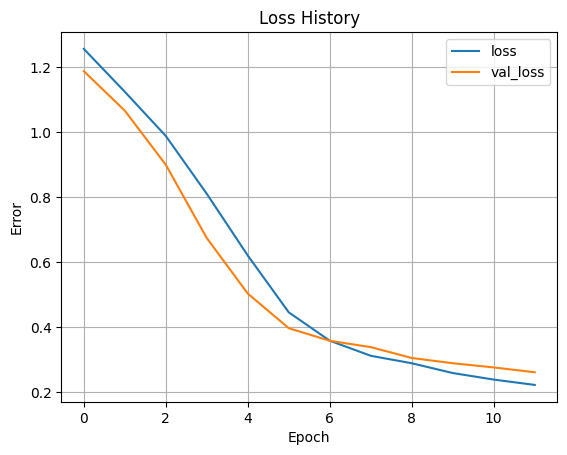

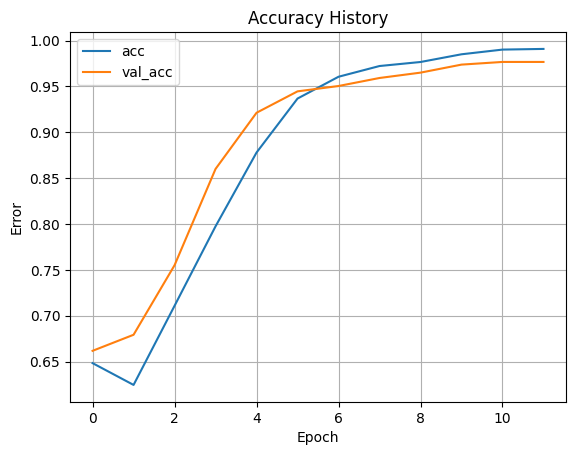

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title("Loss History")
plt.show()

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title("Accuracy History")
plt.grid(True)

In [ ]:
from sklearn.metrics import precision_recall_curve, fbeta_score

y_probs = model.predict(test_encodings)
y_probs = y_probs.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

fbeta_scores = []
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    score = fbeta_score(y_test, y_pred,beta=0.5,average='binary',pos_label=1)
    fbeta_scores.append(score)

fbeta_scores = np.array(fbeta_scores)
best_idx = fbeta_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F-Beta Score: {fbeta_scores[best_idx]:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
Best Threshold: 0.8815
Best F-Beta Score: 0.9773


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step
Accuracy Score: 0.97953216374269
F1 Score: 0.9608938547486033
Recall Score: 0.9885057471264368
Precision Score: 0.9347826086956522
Classification Report: 
              precision    recall  f1-score   support

NotPromotion       0.98      1.00      0.99       250
   Promotion       0.99      0.93      0.96        92

    accuracy                           0.98       342
   macro avg       0.98      0.97      0.97       342
weighted avg       0.98      0.98      0.98       342

Confusion Matrix:



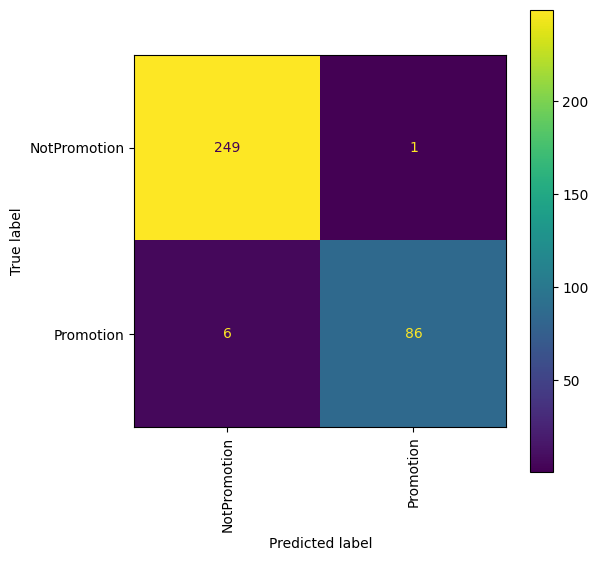

In [ ]:
pred = model.predict(test_encodings)
y_pred = [0 if pred < best_threshold else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(y_pred, y_test)}")
print(f"F1 Score: {f1_score(y_pred, y_test)}")
print(f"Recall Score: {recall_score(y_pred, y_test)}")
print(f"Precision Score: {precision_score(y_pred, y_test)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(6,6))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [32]:
for idx,i in enumerate(y_pred):
    if i != y_test[idx]:
        print("***",idx+1,"| pred:", i, "| label:", y_test[idx], texts_test[idx])
        continue
    print(idx+1,"| pred:", i, "| label:", y_test[idx], texts_test[idx])

1 | pred: 1 | label: 1 INFO CINA777APK CINA777RTP CINA777Logo24/11/2024 ( Min ) 14.56 ( GMT+07 ) Versi MobileVersi WAP ( NEX4D ) Nama PenggunaKata SandiLupa Kata Sandi ? DaftarHomeTogelHot GamesSlotsLive CasinoOlahragaCrash GameArcadePokerE-SportsSabung AyamPromosiWelcome to situs resmi CINA777 | Kami membayar berapapun kemenangan player.HasilPasaranBuku MimpiHasil TerakhirStatistik MarketGame PopulerMahjong Wins 3 – Black ScatterMAINMahjong Wins 3 – Black ScatterMahjong WaysMAINMahjong WaysMighty HerculesMAINMighty HerculesSlot88 BonanzaMAINSlot88 BonanzaLe PharaohMAINLe PharaohPirate Quest 1000MAINPirate Quest 1000SixSixSixMAINSixSixSixWay of NinjaMAINWay of Ninja888 GoldMAIN888 GoldMahjong Ways 2MAINMahjong Ways 2Gates of Olympus 1000™MAINGates of Olympus 1000™Wild Bounty ShowdownMAINWild Bounty ShowdownLucky Twins NexusMAINLucky Twins NexusNexus Koi GateMAINNexus Koi GateThe CryptMAINThe CryptLucky Twins Power ClustersMAINLucky Twins Power ClustersMentalMAINMentalFortune Gems 2MAIN

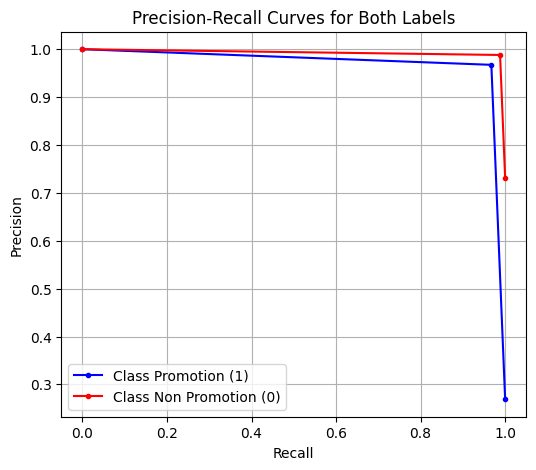

In [33]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred)

# Compute precision-recall values for class 0 (negative class)
y_scores_neg = 1 - np.array(y_pred)  # Since model predicts class 1 probabilities, class 0 is (1 - probability)
precision_0, recall_0, _ = precision_recall_curve(1 - y_test, y_scores_neg)

# Plot Precision-Recall curves for both classes
plt.figure(figsize=(6, 5))
plt.plot(recall_1, precision_1, marker='.', label=f'Class Promotion (1)', color='blue')
plt.plot(recall_0, precision_0, marker='.', label=f'Class Non Promotion (0)', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Both Labels')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def predict_sentiment(text):
    use_text = preprocess_text(text)
    inputs = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    use_text = inputs['input_ids']
    use_text = tf.keras.preprocessing.sequence.pad_sequences(use_text, maxlen=512, padding="post")

    pred = model.predict(use_text)
    # pred_labels = tf.argmax(pred, axis=1)
    pred_labels = [0 if pred < 0.5 else 1 for pred in pred]
    # print(pred)
 
    pred_labels = [label_type[label] for label in pred_labels]
    for index, preds in enumerate(pred_labels):
        print(f"{text[index]}: {preds}")
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs    yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar."
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Aku seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial , Cak Imin : 8,8 Juta Pasien Minta Direhabilitasi Jumat , 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang xxtoto: Promotion
top up kantorbola pasti gampang menangnya: NotPromotion
gratis koin buruan topup agencasinoindonesia: NotPromotion
gratis koin buruan topup fairbet88.com , segera daftarkan akun: Promotion
DEWA-DORA tuh situs paling enak withdraw tiap hari ! 😖 😣: Promotion
DEWA-DORA tuh situs paling gampang narik tiap hari ! 😖 😣: Promotion
Gua setia maen DEWADORA , tempat terbaik !: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung Menang berapapun dibayar .: Promotion
